In [1]:
import pandas as pd
data_30_sentences = pd.read_csv(r'C:\Users\erich\Desktop\DS_project\data\data_30_sentences.csv')

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def data_binary(df):
    
    df = df[df['HTML_Content'].isin(['Teen And Up Audiences', 'Mature'])]
    
    df = df.dropna(subset=['TXT_Content'])

    def clean_text(text):

        if not isinstance(text, str):
            text = str(text)

        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        tokenized_text = word_tokenize(text)
        cleaned_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in set(stopwords.words('english'))]

        return ' '.join(cleaned_text)

    df['TXT_Content'] = df['TXT_Content'].apply(clean_text)

    return df

data_30_sentences = data_binary(data_30_sentences)
print(data_30_sentences)

C:\Users\erich\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


               HTML_Content                                        TXT_Content
0     Teen And Up Audiences  huckleberry finn stood front old wooden door m...
1     Teen And Up Audiences  right huck trying figure every sort way could ...
3     Teen And Up Audiences  air hot brow wet mind exhausted st petersburg ...
5     Teen And Up Audiences  rope burned skin rubbing flesh raw shoved push...
6     Teen And Up Audiences  tom sawyer liked consider hopeless romantic ot...
...                     ...                                                ...
6030                 Mature  sorry late robin blurted soon within earshot c...
6036  Teen And Up Audiences  seen news pat asked robin chance hang coat mor...
6037  Teen And Up Audiences  free next friday night murphy smiled phone rob...
6038                 Mature  turned walked away wan na say come baby give w...
6040                 Mature  heaven fact unlike earth pro con pro include t...

[3055 rows x 2 columns]


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, Attention
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import time


# Pre-processing
max_length = 300
embedding_dim = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_30_sentences['TXT_Content'])
sequences = tokenizer.texts_to_sequences(data_30_sentences['TXT_Content'])
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_length)

labels = to_categorical(np.asarray(LabelEncoder().fit_transform(data_30_sentences['HTML_Content'])))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Word Embedding
glove_input_file = 'C:\\Users\\erich\\Desktop\\DS_project\\code\\glove.6B\\glove.6B.100d.txt'
word2vec_output_file = 'C:\\Users\\erich\\Desktop\\DS_project\\code\\glove.6B\\glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

word2vec = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word] 

C:\Users\erich\AppData\Local\Temp\ipykernel_30740\460413102.py:34: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [4]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, trainable=False))
model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels[0]), activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=3, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

model.reset_states()

history_10 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/3
16/16 [==============================] - 294s 18s/step - loss: 0.6632 - accuracy: 0.6251 - precision: 0.6251 - recall: 0.6251 - val_loss: 0.6490 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 2/3
16/16 [==============================] - 288s 18s/step - loss: 0.6611 - accuracy: 0.6373 - precision: 0.6373 - recall: 0.6373 - val_loss: 0.6510 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 3/3
16/16 [==============================] - 378s 24s/step - loss: 0.6519 - accuracy: 0.6368 - precision: 0.6368 - recall: 0.6368 - val_loss: 0.6616 - val_accuracy: 0.6380 - val_precision: 0.6380 - val_recall: 0.6380
Epoch 1/10
16/16 [==============================] - 366s 23s/step - loss: 0.6436 - accuracy: 0.6440 - precision: 0.6440 - recall: 0.6440 - val_loss: 0.6783 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 2/10
16/16 [==============================] - 325s 20s/step - loss: 0.6520 - accuracy: 0.6404 - preci

In [4]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, trainable=True))
model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels[0]), activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=3, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

model.reset_states()

history_10 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/3
16/16 [==============================] - 358s 22s/step - loss: 0.6687 - accuracy: 0.6107 - precision: 0.6107 - recall: 0.6107 - val_loss: 0.6551 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 2/3
16/16 [==============================] - 377s 24s/step - loss: 0.6594 - accuracy: 0.6384 - precision: 0.6384 - recall: 0.6384 - val_loss: 0.6545 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 3/3
16/16 [==============================] - 380s 24s/step - loss: 0.6560 - accuracy: 0.6384 - precision: 0.6384 - recall: 0.6384 - val_loss: 0.6513 - val_accuracy: 0.6462 - val_precision: 0.6462 - val_recall: 0.6462
Epoch 1/10
16/16 [==============================] - 352s 22s/step - loss: 0.6420 - accuracy: 0.6491 - precision: 0.6491 - recall: 0.6491 - val_loss: 0.6687 - val_accuracy: 0.6503 - val_precision: 0.6503 - val_recall: 0.6503
Epoch 2/10
16/16 [==============================] - 391s 25s/step - loss: 0.6273 - accuracy: 0.6655 - preci

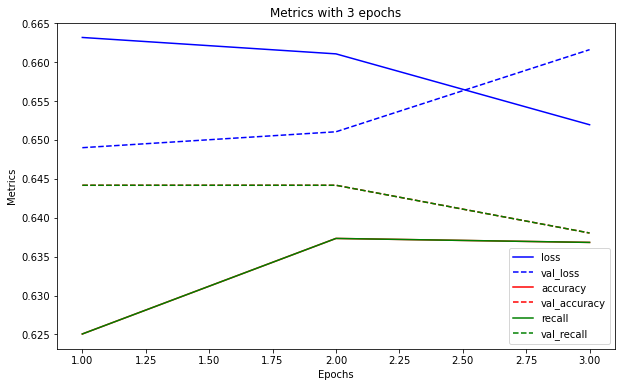

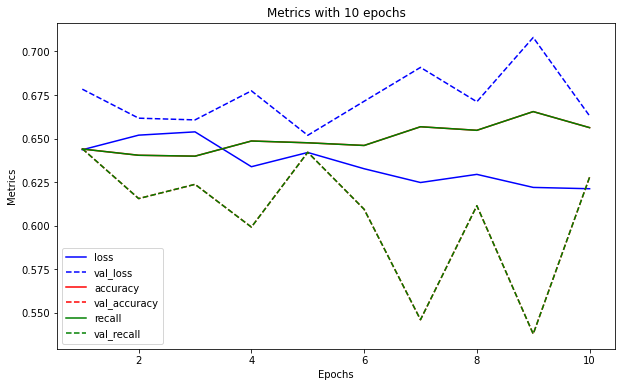

In [5]:
import matplotlib.pyplot as plt
import os

def plot_metrics(history, title, save_dir):
    metrics = ['loss', 'accuracy', 'recall']
    colors = ['blue', 'red', 'green']
    
    plt.figure(figsize=(10, 6))

    for i, metric in enumerate(metrics):

        metric_data = history.history[metric]
        val_metric_data = history.history['val_'+metric]

        epochs = range(1, len(metric_data) + 1)

        plt.plot(epochs, metric_data, color=colors[i], label=metric)
        plt.plot(epochs, val_metric_data, color=colors[i], linestyle="--", label='val_'+metric)
        
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()


    plt.savefig(os.path.join(save_dir, title.replace(' ', '_')+'.png'))

    plt.show()


save_dir = 'C:\\Users\\erich\\Desktop\\DS_project\\data\\pic'
os.makedirs(save_dir, exist_ok=True)

plot_metrics(history_3, 'Metrics with 3 epochs', save_dir)
plot_metrics(history_10, 'Metrics with 10 epochs', save_dir)

In [4]:
from keras.layers import Embedding, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels[0]), activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=3, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

model.reset_states()

history_10 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])


Epoch 1/3
16/16 [==============================] - 2109s 134s/step - loss: 0.6695 - accuracy: 0.6087 - precision: 0.6087 - recall: 0.6087 - val_loss: 0.6872 - val_accuracy: 0.5971 - val_precision: 0.5971 - val_recall: 0.5971
Epoch 2/3
16/16 [==============================] - 2699s 170s/step - loss: 0.6649 - accuracy: 0.6251 - precision: 0.6251 - recall: 0.6251 - val_loss: 0.6605 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 3/3
16/16 [==============================] - 3045s 189s/step - loss: 0.6631 - accuracy: 0.6389 - precision: 0.6389 - recall: 0.6389 - val_loss: 0.6565 - val_accuracy: 0.6442 - val_precision: 0.6442 - val_recall: 0.6442
Epoch 1/10
16/16 [==============================] - 3186s 199s/step - loss: 0.6532 - accuracy: 0.6409 - precision: 0.6409 - recall: 0.6409 - val_loss: 0.6586 - val_accuracy: 0.6421 - val_precision: 0.6421 - val_recall: 0.6421
Epoch 2/10
16/16 [==============================] - 3585s 224s/step - loss: 0.6423 - accuracy: 0.64